In [1]:
import xarray as xr
import numpy as np
import cmocean as cm
import os
import pandas as pd
from matplotlib import cm as cmap
%matplotlib inline

In [2]:
from dask.distributed import Client

In [3]:
c=Client()
c

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45179 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/45179/status,
Dashboard: /proxy/45179/status,Workers: 6
Total threads: 24,Total memory: 96.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43675,Workers: 6
Dashboard: /proxy/45179/status,Total threads: 24
Started: Just now,Total memory: 96.00 GiB
Comm: tcp://10.6.72.24:36665,Total threads: 4
Dashboard: /proxy/37343/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:41901,


In [4]:
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as feature
import matplotlib.ticker as mticker
import cmocean as cm

In [5]:
land_50m = feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='#DFD1AF',
                                        linewidth=0.2)

In [47]:
import matplotlib
#matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["text.latex.preamble"] = r'\usepackage{xfrac}'

In [48]:
climatology_path = '/home/156/jm5970/hh5/climatology_V2/'

In [60]:
MKE = xr.open_dataset(climatology_path+'./MKE_climatology.nc').rename({'__xarray_dataarray_variable__':'MKE','latitude':'lat','longitude':'lon'})/10000
MEKE = xr.open_dataset(climatology_path+'./MEKE_climatology.nc').rename({'EKE_eddy':'MEKE'})
MCEKE = xr.open_dataset(climatology_path+'./MTEKE_climatology.nc').rename({'EKE_eddy':'MCEKE'})
MREKE = xr.open_dataset(climatology_path+'./MTRKE_climatology.nc').rename({'EKE_res':'MREKE'})
MREKE_c = xr.open_dataset(climatology_path+'./MTRKE_c_climatology.nc').rename({'TEKE_c':'MREKE_c'})

In [77]:
bathymetry = xr.open_dataset('/home/156/jm5970/v45/data.input/bathymetry_025deg.nc')#.sel(lon=slice(-180,179.983333))

In [78]:
gridded_depth = bathymetry.interp(lon = (MEKE.lon.values), lat = MEKE.lat.values).elevation.compute()

In [79]:
gridded_depth = gridded_depth.assign_coords({"lon": (((gridded_depth.lon) % 360))}).sortby('lon')#.rename({'x':'lon','y':'lat'})#.plot()

In [81]:
lat_radians=np.radians(MKE.lat)
lon_radians=np.radians(MKE.lon)
earth_radius = 6371e3

grad_lon=lon_radians.copy()
grad_lon.data=np.gradient(lon_radians)

dx=grad_lon*earth_radius*np.cos(lat_radians)
dy=np.gradient(lat_radians)*earth_radius

area = (dx*dy).where(abs(dx.lat)>5)
area = area.where(np.isfinite(MEKE.MEKE))

In [82]:
MKE = (MKE).where(abs(MKE.lat)<60).where(abs(MKE.lat)>5).where(gridded_depth < -1000)
MEKE = (MEKE).where(abs(MKE.lat)<60).where(abs(MKE.lat)>5).where(gridded_depth < -1000)
MCEKE = (MCEKE).where(abs(MKE.lat)<60).where(abs(MKE.lat)>5).where(gridded_depth < -1000)
MREKE = (MREKE).where(abs(MKE.lat)<60).where(abs(MKE.lat)>5).where(gridded_depth < -1000)
MREKE_c = MREKE_c.where(abs(MKE.lat)<60).where(abs(MKE.lat)>5).where(gridded_depth < -1000)

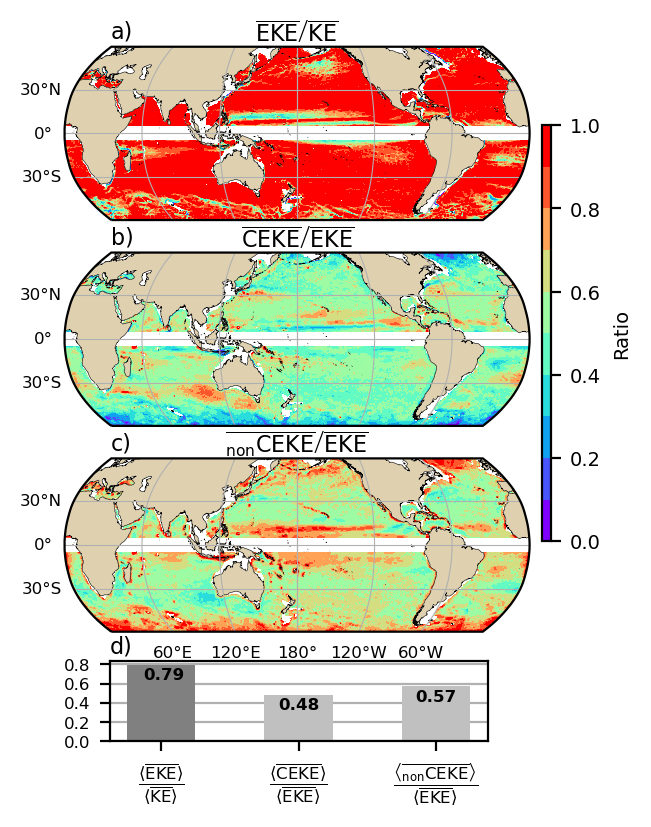

In [83]:
cmap = 'rainbow'

cbar_kwargs=dict(pad=0.15, shrink=1, label=r'')

fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(3, 4),dpi=200, 
                                    subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})
# Ratios
MEKE_MKE_ratio = (MEKE.MEKE/MKE.MKE).where(gridded_depth < -1000)
MCEKE_MEKE_ratio = (MCEKE.MCEKE/MEKE.MEKE).where(gridded_depth < -1000)
MREKE_MEKE_ratio = (MREKE.MREKE/MEKE.MEKE).where(gridded_depth < -1000)

MEKE_MKE_ratio= MEKE_MKE_ratio.where(MEKE_MKE_ratio<1)
MCEKE_MEKE_ratio= MCEKE_MEKE_ratio.where(MCEKE_MEKE_ratio<1)
MREKE_MEKE_ratio= MREKE_MEKE_ratio.where(MREKE_MEKE_ratio<1)

## Subplot
clm = MEKE_MKE_ratio.plot.contourf(ax=ax1,transform =ccrs.PlateCarree(),cmap=cmap,
                          vmin=0,vmax=1, add_colorbar = False,levels=11)
for c in clm.collections:
    c.set_rasterized(True)
    
ax1.set_extent([0.1,359.99,-60, 60], crs=ccrs.PlateCarree())
ax1.add_feature(land_50m)
ax1.set_title(r'$\overline{\mathrm{EKE}}\left/\overline{\mathrm{KE}}\right.$', fontsize=8, pad=2)

## Subplot

clm2 = MCEKE_MEKE_ratio.plot.contourf(ax=ax2,transform =ccrs.PlateCarree(),cmap=cmap,
                                vmin=0,vmax=1, add_colorbar = False,levels=11)
for c in clm2.collections:
    c.set_rasterized(True)
    
ax2.set_extent([0.1,359.99,-60, 60], crs=ccrs.PlateCarree())
ax2.add_feature(land_50m)
ax2.set_title(r'$\overline{\mathrm{CEKE}}\left/\overline{\mathrm{EKE}}\right.$', fontsize=8, pad=2)

## Subplot
clm3 = MREKE_MEKE_ratio.plot.contourf(ax=ax3,transform =ccrs.PlateCarree(),cmap=cmap,
                                vmin=0,vmax=1, add_colorbar = False,levels=11)
for c in clm3.collections:
    c.set_rasterized(True)
    
ax3.set_extent([0.1,359.99,-60, 60], crs=ccrs.PlateCarree())
ax3.add_feature(land_50m)
ax3.set_title(r'$\overline{\mathrm{_{non}CEKE}}\left/\overline{\mathrm{EKE}}\right.$', fontsize=8, pad=2)

cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.52])
cbar=fig.colorbar(clm3, cax=cbar_ax, orientation='vertical')
cbar.set_label('Ratio', rotation=90, fontsize=7)
cbar.ax.tick_params(labelsize=7) 

sum_dict = {r'$\dfrac{\mathrm{MKE}}{\mathrm{MKE}}$':MKE.MKE.where(abs(MKE.lat)>5).sum().compute()/area.sum(),
             r'$\dfrac{\mathrm{MEKE}}{\mathrm{MKE}}$':MEKE.MEKE.where(abs(MKE.lat)>5).sum().compute()/area.sum(),
             r'$\dfrac{\mathrm{MCEKE}}{\mathrm{MEKE}}$':MCEKE.MCEKE.where(abs(MKE.lat)>5).sum().compute()/area.sum(),
             r'$\dfrac{\mathrm{MnCEKE}}{\mathrm{MEKE}}$':MREKE.MREKE.where(abs(MKE.lat)>5).sum().compute()/area.sum()}

df_sums = pd.DataFrame.from_dict(sum_dict, orient='index')
ax4 = fig.add_axes([0.2, 0, 0.63, 0.1])

ax4.bar(0,(df_sums[0][1]/df_sums[0][0]),color='gray',width=0.5,zorder=2)

# loc = [0]
# for i,v in enumerate((df_sums[1::]/df_sums[0][0]).values):
v = df_sums[0][1]/df_sums[0][0]
ax4.text(0 - 0.13, v - 0.15, str(v.round(2)), color='k', fontweight='bold',fontsize=6)

ax4.bar([1,2],((df_sums/df_sums[0][1])[2::]).values.T[0],color='silver',width=0.5,zorder=2)

loc = [1, 2]
for i,v in enumerate(((df_sums/df_sums[0][1])[2::]).values.T[0]):
    ax4.text(loc[i]- 0.15, v - 0.15, str(v.round(2)), color='k', fontweight='bold',fontsize=6)
    
#ax4.tick_params(labelrotation=90)
ax4.grid(axis='y',zorder=-1)

plt.yticks(np.round(np.arange(0,0.9,0.2),1),np.round(np.arange(0,0.9,0.2),1),fontsize=6)

plt.xticks([0,1,2], [r'$\dfrac{\left<\overline{\mathrm{EKE}}\right>}{\left<\overline{\mathrm{KE}}\right>}$',
                     r'$\dfrac{\left<\overline{\mathrm{CEKE}}\right>}{\left<\overline{\mathrm{EKE}}\right>}$',
                     r'$\dfrac{\left<\overline{\mathrm{_{non}CEKE}}\right>}{\left<\overline{\mathrm{EKE}}\right>}$'],fontsize=6)#,rotation=0)

ax1.text(0.1,1.05,r'a)',fontsize=8,transform=ax1.transAxes)
ax2.text(0.1,1.05,r'b)',fontsize=8,transform=ax2.transAxes)
ax3.text(0.1,1.05,r'c)',fontsize=8,transform=ax3.transAxes)
ax4.text(0,1.1,r'd)',fontsize=8,transform=ax4.transAxes)

gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=0.4)
gl.xlabel_style = {'size': 6}
gl.ylabel_style = {'size': 6}
gl.rotate_labels = False
gl.top_labels = False
gl.bottom_labels=False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180,181,60))
gl.ylocator = mticker.FixedLocator(np.arange(-30,60,30))

gl = ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=0.4)
gl.xlabel_style = {'size': 6}
gl.ylabel_style = {'size': 6}
gl.rotate_labels = False
gl.top_labels = False
gl.right_labels = False
gl.bottom_labels=False
gl.xlocator = mticker.FixedLocator(np.arange(-180,181,60))
gl.ylocator = mticker.FixedLocator(np.arange(-30,60,30))

gl = ax3.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=0.4)
gl.xlabel_style = {'size': 6}
gl.ylabel_style = {'size': 6}
gl.rotate_labels = False
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180,181,60))
gl.ylocator = mticker.FixedLocator(np.arange(-30,60,30))

plt.subplots_adjust(wspace=0.05, hspace=0.07)
plt.savefig('./Figure_3_eke_ratio_map.pdf',dpi=300,bbox_inches='tight')